In [4]:
import pandas as pd
import numpy as np
import os

# данные


In [161]:
data = []
for file in sorted(os.listdir('shipments/')):
    data.append(file)
shipments = pd.read_csv('shipments/' + data[0])
for d in data[1:]:
    shipments = pd.concat([shipments, pd.read_csv(str('shipments/' + d))]).reset_index(drop=True)

user = pd.read_csv('misc/user_profiles_Nastya.csv')

data = []
for file in sorted(os.listdir('line_items01/')):
    data.append(file)
line01 = pd.read_csv('line_items01/' + data[0])
for d in data[1:]:
    line01 = pd.concat([line01, pd.read_csv(str('line_items01/' + d))])

In [63]:
ship_user = pd.merge(shipments, user, on='user_id', how='left')

ship_user['age'] = ship_user['age'].replace(0, np.nan)

In [64]:
ship_user_line01 = pd.merge(ship_user, line01, on='shipment_id', how='left')

In [65]:
brands_stats = ship_user_line01['brand_name'].value_counts() 

big_brands = brands_stats[brands_stats > 3000].index

ship_user_line01.at[~ship_user_line01['brand_name'].isin(big_brands), 'brand_name'] = np.nan

In [11]:
dates = ['order_created_at', 'order_completed_at', 'shipped_at', 'shipment_starts_at', 'bdate', 'created_at']

cats = []
for col in ship_user_line01.columns:
    if col not in dates:
        if ship_user_line01[col].dtype == 'object':
            cats.append(col)
            print(col, len(ship_user_line01[col].value_counts()))

retailer 46
s.order_state 4
shipment_state 7
s.city_name 97
dw_kind 3
platform 2
os 6
gender 2
brand_name 130
pricer 4


In [13]:
mess = pd.read_csv('messages/messages.csv')
actions = pd.read_csv('messages/actions-labeled.csv').drop('Unnamed: 0', axis=1)
mess_act = pd.merge(mess, actions, left_on='action_id', right_on='id')

mess_act.head()

,sent,action_id,user_id,id,subject,body,type,type_subject
0,1.588847e+09,1512.0,1775692,1512,Сегодня готовим брауни с M&M's 😋 Приступим?,Видео рецепт и все необходимые ингредиенты уже...,email,коммуникация
1,1.588847e+09,1512.0,1775687,1512,Сегодня готовим брауни с M&M's 😋 Приступим?,Видео рецепт и все необходимые ингредиенты уже...,email,коммуникация
2,1.588847e+09,1512.0,1775684,1512,Сегодня готовим брауни с M&M's 😋 Приступим?,Видео рецепт и все необходимые ингредиенты уже...,email,коммуникация
3,1.588847e+09,1512.0,1775678,1512,Сегодня готовим брауни с M&M's 😋 Приступим?,Видео рецепт и все необходимые ингредиенты уже...,email,коммуникация
4,1.588847e+09,1512.0,1775660,1512,Сегодня готовим брауни с M&M's 😋 Приступим?,Видео рецепт и все необходимые ингредиенты уже...,email,коммуникация


In [28]:
ship_user_line01['shipment_state'].value_counts()

shipped          4048312
canceled          351854
ready                503
collecting           486
ready_to_ship        412
shipping             304
pending               28
Name: shipment_state, dtype: int64

In [261]:
ship_user_line01['shipment_time'] = (pd.to_datetime(ship_user_line01['shipped_at']) - pd.to_datetime(ship_user_line01['shipment_starts_at']))



In [267]:
ship_user_line01['shipment_time'].value_counts().sort_index(ascending=False)

20 days 02:08:17       1
15 days 19:53:44       1
10 days 17:49:35       1
9 days 17:34:07        1
9 days 06:44:18        1
                      ..
-27 days +04:15:20     1
-28 days +17:25:47     1
-31 days +23:11:28    33
-32 days +15:01:24     1
-61 days +05:09:39     1
Name: shipment_time, Length: 40555, dtype: int64

In [59]:
users_cancelled = ship_user_line01[ship_user_line01['shipment_state'] == 'canceled'].groupby('user_id')['shipment_state'].agg('count')

users_shipped = ship_user_line01[ship_user_line01['shipment_state'] == 'shipped'].groupby('user_id')['shipment_state'].agg('count')

ship_user_line01 = ship_user_line01.join(users_shipped, rsuffix='_shipped_count')
ship_user_line01 = ship_user_line01.join(users_cancelled, rsuffix='_cancelled_count')

In [20]:
ship_user_line01['order_completed_at'] = pd.to_datetime(ship_user_line01['order_completed_at'])

In [21]:
ship_user_line01['month'] = ship_user_line01['order_completed_at'].dt.to_period('M')

# модель на маленьком датасете (агрегаты по 3 переменным)

In [69]:
old_ids = set(sample_submission['Id']) & set(train['phone_id'])

sample_submission.at[sample_submission['Id'].isin(old_ids),'Predicted'] = 1

sample_submission.Predicted = sample_submission.Predicted.astype(int)

In [157]:
train = pd.read_csv('train/train.csv')
sample_submission = pd.read_csv('sample_submission.csv', sep=';')

In [162]:
addr = pd.read_csv('misc/addresses.csv')

In [64]:
train_full = pd.merge(train, addr, left_on='phone_id', right_on='phone_id', how='left')

In [175]:
submission_full = pd.merge(sample_submission, addr, left_on='Id', right_on='phone_id',how='left')

In [180]:
shipments_with_userid = pd.merge(shipments, addr, left_on='ship_address_id', right_on='id',how='left')

In [250]:
shipments_with_userid.order_completed_at = pd.to_datetime(shipments_with_userid.order_completed_at)

In [326]:
used_cols = ['total_cost','promo_total','total_weight']
def foo(group_col):
    to_mean = True
    to_std = True
    to_minmax = True
    to_std_score = True
    unite_rare_groups = False
    min_group_size = 100
    use_oleg_attenuation = False
    oleg_midpoint =0

    data = []
    indices = []
    for month in [8]:
        mdata = group_col[group_col.order_completed_at.dt.month==month]
        for col in used_cols:            
            dmean = mdata[[col]].agg('mean').iloc[0]
            dstd = mdata[[col]].agg('std').replace(-np.inf, np.nan).replace(np.inf, np.nan).fillna(0).iloc[0]
            data+=[dmean,dstd]
            indices += [(f'2020-0{month}',f'{col}_dmean'),(f'2020-0{month}',f'{col}_dstd')]

    
    return pd.Series(data, index=pd.MultiIndex.from_tuples(indices, names=['month', 'feature']))

In [254]:
v_features=shipments_with_userid[['phone_id','order_completed_at']+used_cols].groupby('phone_id').apply(foo)
v_features.to_csv('./tmp_vb.csv')

In [268]:
df = v_features.copy()

In [324]:
shipments_with_userid_aug = shipments_with_userid[shipments_with_userid.order_completed_at.dt.month == 8]

In [327]:
v_features_aug = shipments_with_userid_aug[['phone_id','order_completed_at']+used_cols].groupby('phone_id').apply(foo)


In [328]:
v_features_aug.to_csv('aug.csv')

In [304]:
X = df.T.unstack(level=0).T.reset_index()

train_merged = pd.merge(train, X, left_on=['phone_id','order_completed_at'], right_on=['phone_id', 'month'], how='right')

train_merged_notnan = train_merged.dropna(subset=['target'])

train_columns = ['promo_total_dmean', 'promo_total_dstd', 'total_cost_dmean',
       'total_cost_dstd', 'total_weight_dmean', 'total_weight_dstd']

X = train_merged_notnan.drop('target',axis=1)
y = train_merged_notnan.target

In [330]:
aug = v_features_aug.T.unstack(level=0).T.reset_index()

In [335]:
sub = pd.merge(sample_submission, aug, left_on=['Id'], right_on=['phone_id'], how='left')



In [337]:
make_ones = sub[sub['month'].isna()].Id

In [354]:
# warnings.simplefilter('ignore')
import time
from numba import jit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import KFold
import gc
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

# @jit
def fast_auc(y_true, y_prob):
    """
    fast roc_auc computation: https://www.kaggle.com/c/microsoft-malware-prediction/discussion/76013
    """
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    
    nfalse = 0
    auc = 0
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

def eval_auc(y_true, y_pred):
    """
    Fast auc eval function for lgb.
    """
#     print(y_true, y_pred)
#     return 'auc', fast_auc(y_true, y_pred), True
    return 'auc', roc_auc_score(y_true, y_pred), True
def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()
def plot_importance(result_dict, file=None):
    feature_importance = result_dict['feature_importance']
    cols = result_dict['top_columns']
    best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LGB Features (avg over folds)')
    if file is not None:
        plt.savefig(file)
def train_model_classification_vb(X, X_test, y, params, folds, model_type='lgb', eval_metric='auc', columns=None,
                                  plot_feature_importance=True, model=None,
                                  verbose=100, early_stopping_rounds=200, n_estimators=500, splits=None,
                                  averaging='usual', n_jobs=-1, groups=None,
                                  train_1_sample_coef=None, train_0_sample_coef=None,
                                  categorial_columns=None, categorial_encoder=None
                                  ):
    """
    A function to train a variety of classification models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to   plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    """
    columns = X.columns if columns is None else columns
    n_splits = folds.n_splits if splits is None else splits
    if X_test is not None:
        X_test = X_test[columns]

    # to set up scoring parameters
    metrics_dict = {'auc': {'lgb_metric_name': eval_auc,
                            'catboost_metric_name': 'AUC',
                            'sklearn_scoring_function': metrics.roc_auc_score},
                    }

    result_dict = {}
    if averaging == 'usual':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        if X_test is not None:
            prediction = np.zeros((len(X_test), 1))

    elif averaging == 'rank':
        # out-of-fold predictions on train data
        oof = np.zeros((len(X), 1))

        # averaged predictions on train data
        if X_test is not None:
            prediction = np.zeros((len(X_test), 1))

    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()

    # split and train on folds
    if groups is None:
        splitter = folds.split(X, y)
    else:
        splitter = folds.split(X, y, groups=groups)
    for fold_n, (train_index, valid_index) in enumerate(splitter):
        gc.collect()
        if fold_n < folds.n_splits - n_splits:
            continue
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]

        # encode categorial features
        if categorial_encoder is not None:
            print('Encoding categorical features')
            assert categorial_columns is not None
            encoder = categorial_encoder(verbose=1, cols=categorial_columns)
            encoder.fit(X_train, y_train)
            X_train = encoder.transform(X_train)
            X_valid = encoder.transform(X_valid)
            X_test = encoder.transform(X_test)

        # down/upsample train dataset
        if train_0_sample_coef is not None or train_1_sample_coef is not None:
            assert NotImplementedError
            if type(X_train) is np.ndarray:
                assert NotImplementedError
                # train = np.hstack([X_train.values, y_train.reshape((-1,1))])
            else:
                X_train['target'] = y_train

            train_0 = X_train[X_train.target == 0]
            train_1 = X_train[X_train.target == 1]
            if train_0_sample_coef is not None:
                train_0 = train_0.sample(int(train_0.shape[0] * train_0_sample_coef),
                                         random_state=params['random_state'], replace=True)
            if train_1_sample_coef is not None:
                train_1 = train_1.sample(int(train_1.shape[0] * train_1_sample_coef),
                                         random_state=params['random_state'], replace=True)
            train = pd.concat([train_0, train_1], axis=0)
            train = shuffle(train, random_state=params['random_state'])
            X_train = train.drop(['target'], axis=1)
            y_train = train.target
            del train_0
            del train_1
            del train

        if model_type == 'lgb':
            model = lgb.LGBMClassifier(**params, n_estimators=n_estimators, n_jobs=n_jobs)
            model.fit(X_train, y_train,
                      eval_set=[(X_train, y_train), (X_valid, y_valid)],
                      eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                      verbose=verbose, early_stopping_rounds=early_stopping_rounds)
            gc.collect()
            y_pred_valid = model.predict_proba(X_valid, num_iteration=model.best_iteration_)[:, 1]
            if X_test is not None:
                y_pred = model.predict_proba(X_test, num_iteration=model.best_iteration_)[:, 1]

        if model_type == 'xgb':
            if columns is None:
                feature_names = X.columns
            else:
                feature_names = columns
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=feature_names)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=feature_names)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_estimators, evals=watchlist,
                              early_stopping_rounds=early_stopping_rounds, verbose_eval=verbose, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=feature_names),
                                         ntree_limit=model.best_ntree_limit)
            if X_test is not None:
                y_pred = model.predict(xgb.DMatrix(X_test, feature_names=feature_names),
                                       ntree_limit=model.best_ntree_limit)

        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)

            y_pred_valid = model.predict_proba(X_valid)[:, 1].reshape(-1, )
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            if X_test is not None:
                y_pred = model.predict_proba(X_test)[:, 1]

        if model_type == 'keras':
            from keras.models import Model
            from keras.callbacks import Callback, EarlyStopping

            kmodel: Model = model()

            my_callbacks = [EarlyStopping(monitor='aucroc', patience=early_stopping_rounds, verbose=1, mode='max')]

            keras_params = {k: v for k, v in params.items() if k not in ('random_state',)}
            kmodel.fit(X_train, y_train, validation_data=(X_valid, y_valid), **keras_params, callbacks=my_callbacks)
            predict_params = {k: v for k, v in params.items() if k in ['batch_size', 'verbose', 'steps', 'callbacks',
                                                                       'max_queue_size', 'workers',
                                                                       'use_multiprocessing']}
            y_pred_valid = kmodel.predict(X_valid) #, **predict_params
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            if X_test is not None:
                y_pred = kmodel.predict(X_test)[:,0]

        if model_type == 'cat':
            model = CatBoostClassifier(iterations=n_estimators, **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=categorial_columns,
                      use_best_model=True,
                      verbose=True)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            if X_test is not None:
                y_pred = model.predict_proba(X_test)[:, 1]

        if averaging == 'usual':

            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            if X_test is not None:
                prediction += y_pred.reshape(-1, 1)

        elif averaging == 'rank':

            oof[valid_index] = y_pred_valid.reshape(-1, 1)
            scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))
            if X_test is not None:
                prediction += pd.Series(y_pred).rank().values.reshape(-1, 1)

        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    if X_test is not None:
        prediction /= n_splits

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))

    result_dict['oof'] = oof
    if X_test is not None:
        result_dict['prediction'] = prediction
    result_dict['scores'] = scores

    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            result_dict['feature_importance'] = feature_importance
            result_dict['top_columns'] = cols
            plot_importance(result_dict)

    return result_dict

from sklearn.model_selection import GroupKFold

NFOLDS = 3
folds = GroupKFold(n_splits=NFOLDS)

params = {
          'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.1,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 50,
        'n_estimators': 1000,
        'averaging': 'usual',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sun Oct 18 11:14:03 2020
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.746568	training's auc: 0.746568	valid_1's auc: 0.743295	valid_1's auc: 0.743295
[100]	training's auc: 0.749532	training's auc: 0.749532	valid_1's auc: 0.743106	valid_1's auc: 0.743106
Early stopping, best iteration is:
[72]	training's auc: 0.747941	training's auc: 0.747941	valid_1's auc: 0.743324	valid_1's auc: 0.743324
Fold 2 started at Sun Oct 18 11:15:05 2020
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.746656	training's auc: 0.746656	valid_1's auc: 0.743051	valid_1's auc: 0.743051
[100]	training's auc: 0.749669	training's auc: 0.749669	valid_1's auc: 0.742884	valid_1's auc: 0.742884
Early stopping, best iteration is:
[72]	training's auc: 0.748058	training's auc: 0.748058	valid_1's auc: 0.743101	valid_1's auc: 0.743101
Fold 3 started at Sun Oct 18 11:16:08 2020
Training until validation scores don't improve for 50 round

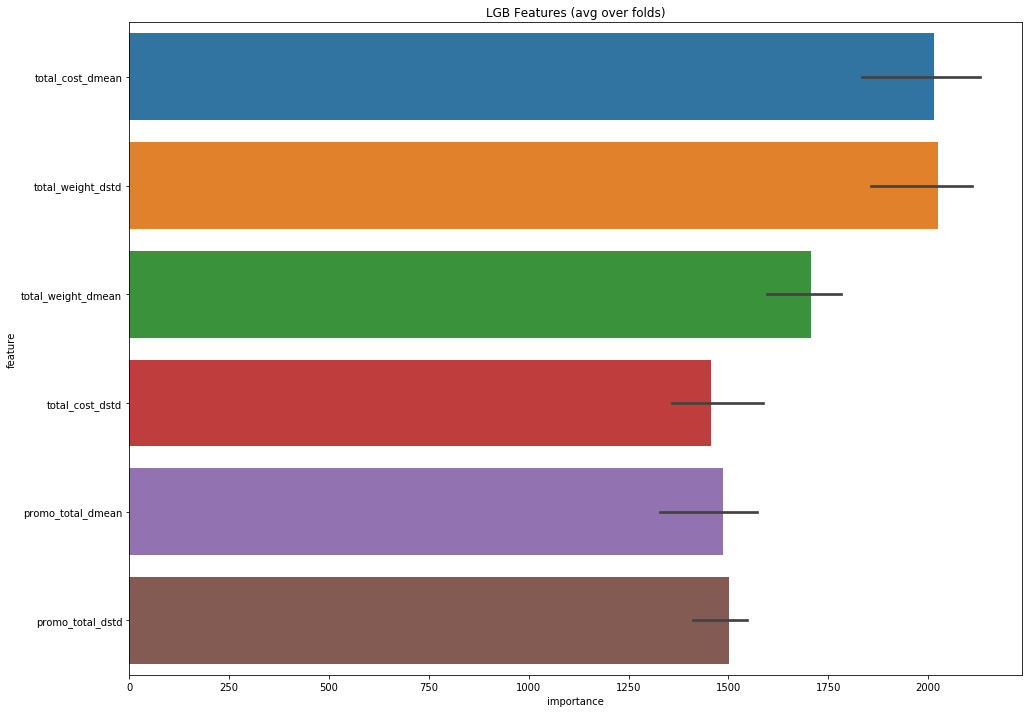

In [362]:
result_dict = train_model_classification_vb( 
                                             X=X, X_test=sub, columns=train_columns,
                                             y=y.astype(np.uint8), params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=50, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=X['phone_id'])




In [365]:

from scipy.optimize import differential_evolution
from sklearn.metrics import matthews_corrcoef
import pandas as pd

 
def choose_tr_mcc(y_true, y_pred):
    '''
    Подбирает порог для бинарной классификации
    :param y_true: Реальные значения {0,1}
    :param y_pred: Предсказанные [0,1]
    :return: Подобранный порог
    '''
    def mcc_eval(x):
        return (-1) * matthews_corrcoef(y_true, (y_pred > x).astype(int))
 
    res = differential_evolution(func=mcc_eval, bounds=[(0, 1)], seed=0)

    return res.x[0]

In [370]:
thres = choose_tr_mcc(y, result_dict['oof'])
thres

/Users/annabaydina/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.5345958506325326

In [462]:
predictions = (result_dict['prediction']>0.36).astype(np.uint8)

df_pred = pd.DataFrame(predictions, columns=['Predicted'], index=sample_submission.Id)

df_pred.loc[make_ones.values, 'Predicted'] += 1 

df_pred.Predicted.sum()

df_pred.to_csv('submission_avb2.csv')

# полный датасет

In [481]:
katya = pd.read_csv('addr_shipments_123_float.csv')

/Users/annabaydina/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [485]:
katya_merged = pd.merge(train, katya, left_on=['phone_id','order_completed_at'], right_on=['phone_id', 'month'], how='right')

In [486]:
katya_merged_notnan = katya_merged.dropna(subset=['target'])

train_columns = ['total_weight_sum', 'total_weight_min', 'total_weight_max',
       'total_weight_mean', 'total_weight_std', 'promo_total_sum',
       'promo_total_min', 'promo_total_max', 'promo_total_mean',
       'promo_total_std', 'rate_sum', 'rate_min', 'rate_max', 'rate_mean',
       'rate_std', 'total_cost_sum', 'total_cost_min', 'total_cost_max',
       'total_cost_mean', 'total_cost_std', 'total_weight_sum_2',
       'total_weight_min_2', 'total_weight_max_2', 'total_weight_mean_2',
       'total_weight_std_2', 'total_weight_sum_3', 'total_weight_min_3',
       'total_weight_max_3', 'total_weight_mean_3', 'total_weight_std_3',
       'total_cost_sum_2', 'total_cost_min_2', 'total_cost_max_2',
       'total_cost_mean_2', 'total_cost_std_2', 'total_cost_sum_3',
       'total_cost_min_3', 'total_cost_max_3', 'total_cost_mean_3',
       'total_cost_std_3', 'rate_sum_2', 'rate_min_2', 'rate_max_2',
       'rate_mean_2', 'rate_std_2', 'rate_sum_3', 'rate_min_3', 'rate_max_3',
       'rate_mean_3', 'rate_std_3', 'promo_total_sum_2', 'promo_total_min_2',
       'promo_total_max_2', 'promo_total_mean_2', 'promo_total_std_2',
       'promo_total_sum_3', 'promo_total_min_3', 'promo_total_max_3',
       'promo_total_mean_3', 'promo_total_std_3']

X = katya_merged_notnan.drop('target',axis=1)
y = katya_merged_notnan.target

In [491]:
X_test = katya_merged[katya_merged.month=='2020-08']

In [493]:
from sklearn.model_selection import GroupKFold

NFOLDS = 3
folds = GroupKFold(n_splits=NFOLDS)

In [559]:
params = {
          'num_leaves': 500,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.03,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47
         }
train_options = {
        "model_type":'lgb',
        "params": params,
        "eval_metric":'auc',
        'early_stopping_rounds': 50,
        'n_estimators': 1000,
        'averaging': 'usual',
        'use_groups': False,
        'fold_name': folds.__class__.__name__,
        'n_splits': NFOLDS
    }

Fold 1 started at Sun Oct 18 13:07:51 2020
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.796068	training's auc: 0.796068	valid_1's auc: 0.761873	valid_1's auc: 0.761873
[100]	training's auc: 0.814451	training's auc: 0.814451	valid_1's auc: 0.76233	valid_1's auc: 0.76233
[150]	training's auc: 0.830437	training's auc: 0.830437	valid_1's auc: 0.762428	valid_1's auc: 0.762428
[200]	training's auc: 0.843368	training's auc: 0.843368	valid_1's auc: 0.762372	valid_1's auc: 0.762372
Early stopping, best iteration is:
[169]	training's auc: 0.835744	training's auc: 0.835744	valid_1's auc: 0.762477	valid_1's auc: 0.762477
Fold 2 started at Sun Oct 18 13:10:14 2020
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.795885	training's auc: 0.795885	valid_1's auc: 0.761542	valid_1's auc: 0.761542
[100]	training's auc: 0.813989	training's auc: 0.813989	valid_1's auc: 0.761864	valid_1's auc: 0.761864
Early stopping, best iteration is

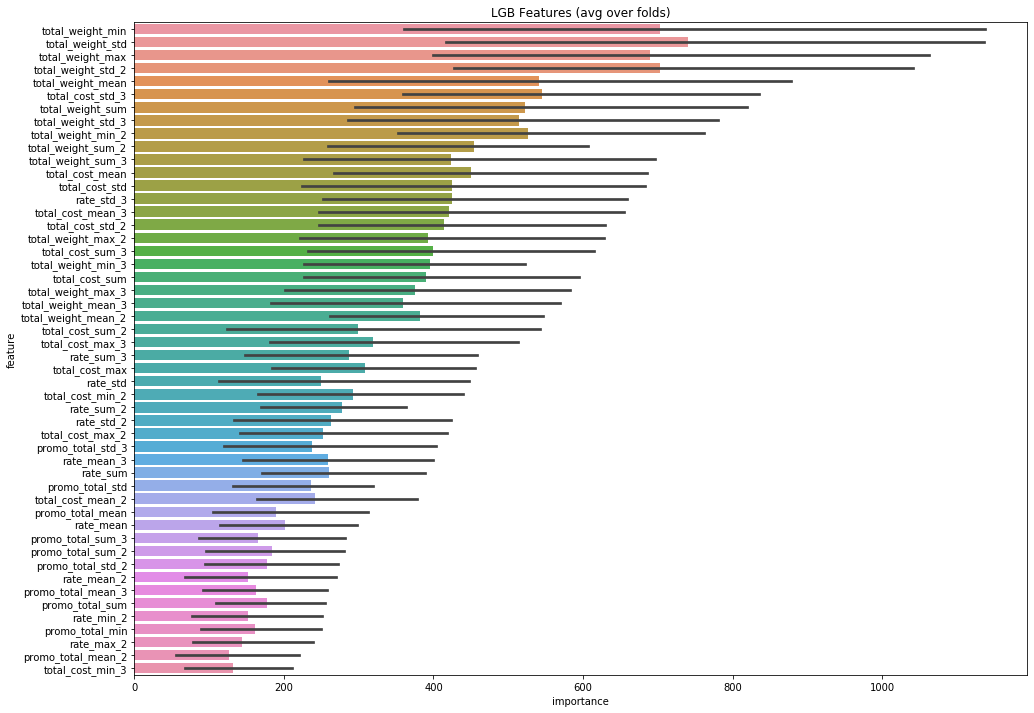

In [560]:
result_dict = train_model_classification_vb( 
                                             X=X, X_test=X_test, columns=train_columns,
                                             y=y.astype(np.uint8), params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=50, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=X['phone_id'])




In [562]:
subkatya = sample_submission.join(pd.DataFrame(result_dict['prediction'], columns=['Predicted'], index=X_test.phone_id),rsuffix='_res', on='Id')

In [563]:
subk = subkatya.fillna(1).drop('Predicted', axis=1).rename(columns={'Predicted_res':'Predicted'}).set_index('Id')

In [564]:
final = subk.reset_index().groupby('Id').Predicted.agg('mean')

In [573]:
fin = pd.DataFrame((final>0.3).astype(np.uint8), columns=['Predicted'])

In [575]:
fin.to_csv('submission_avb6.csv')